In [1]:
from repepo.experiments_2.utils.helpers import (
    SteeringConfig,
    SteeringResult,
    load_results,
    list_subset_of_datasets,
    get_steering_configs_for_datasets
)

datasets = list_subset_of_datasets("dev")
configs = get_steering_configs_for_datasets(
    datasets,
    train_split_name = "train",
    test_split_name = "val",
)

all_results = []
for config in configs:
    results = load_results(config)
    all_results.append((config, results))
    

In [2]:
import matplotlib.pyplot as plt 

def _get_title(config: SteeringConfig):
    return (
        f"{config.train_dataset_name}-"
        f"{config.train_split_name}-"
        f"{config.test_dataset_name}-"
        f"{config.test_split_name}"
    ) 

def plot_in_distribution_data_for_layer(
    ax,
    config: SteeringConfig,
    results: list[SteeringResult]
):

    for layer in config.layers:
        layer_results = [x for x in results if x.layer_id == layer]
        layer_results.sort(key=lambda x: x.multiplier)
        ax.plot(
            [x.multiplier for x in layer_results],
            [x.average_key_prob for x in layer_results],
            label=f"Layer {layer}",
            marker="o",
            linestyle="dashed",
            markersize=5,
            linewidth=2.5,
        )

    # ax.set_ylim(0,1)
    ax.legend()
    ax.set_title(_get_title(config))
    ax.set_xlabel("Multiplier")
    ax.set_ylabel("Probability of answer matching behaviour")

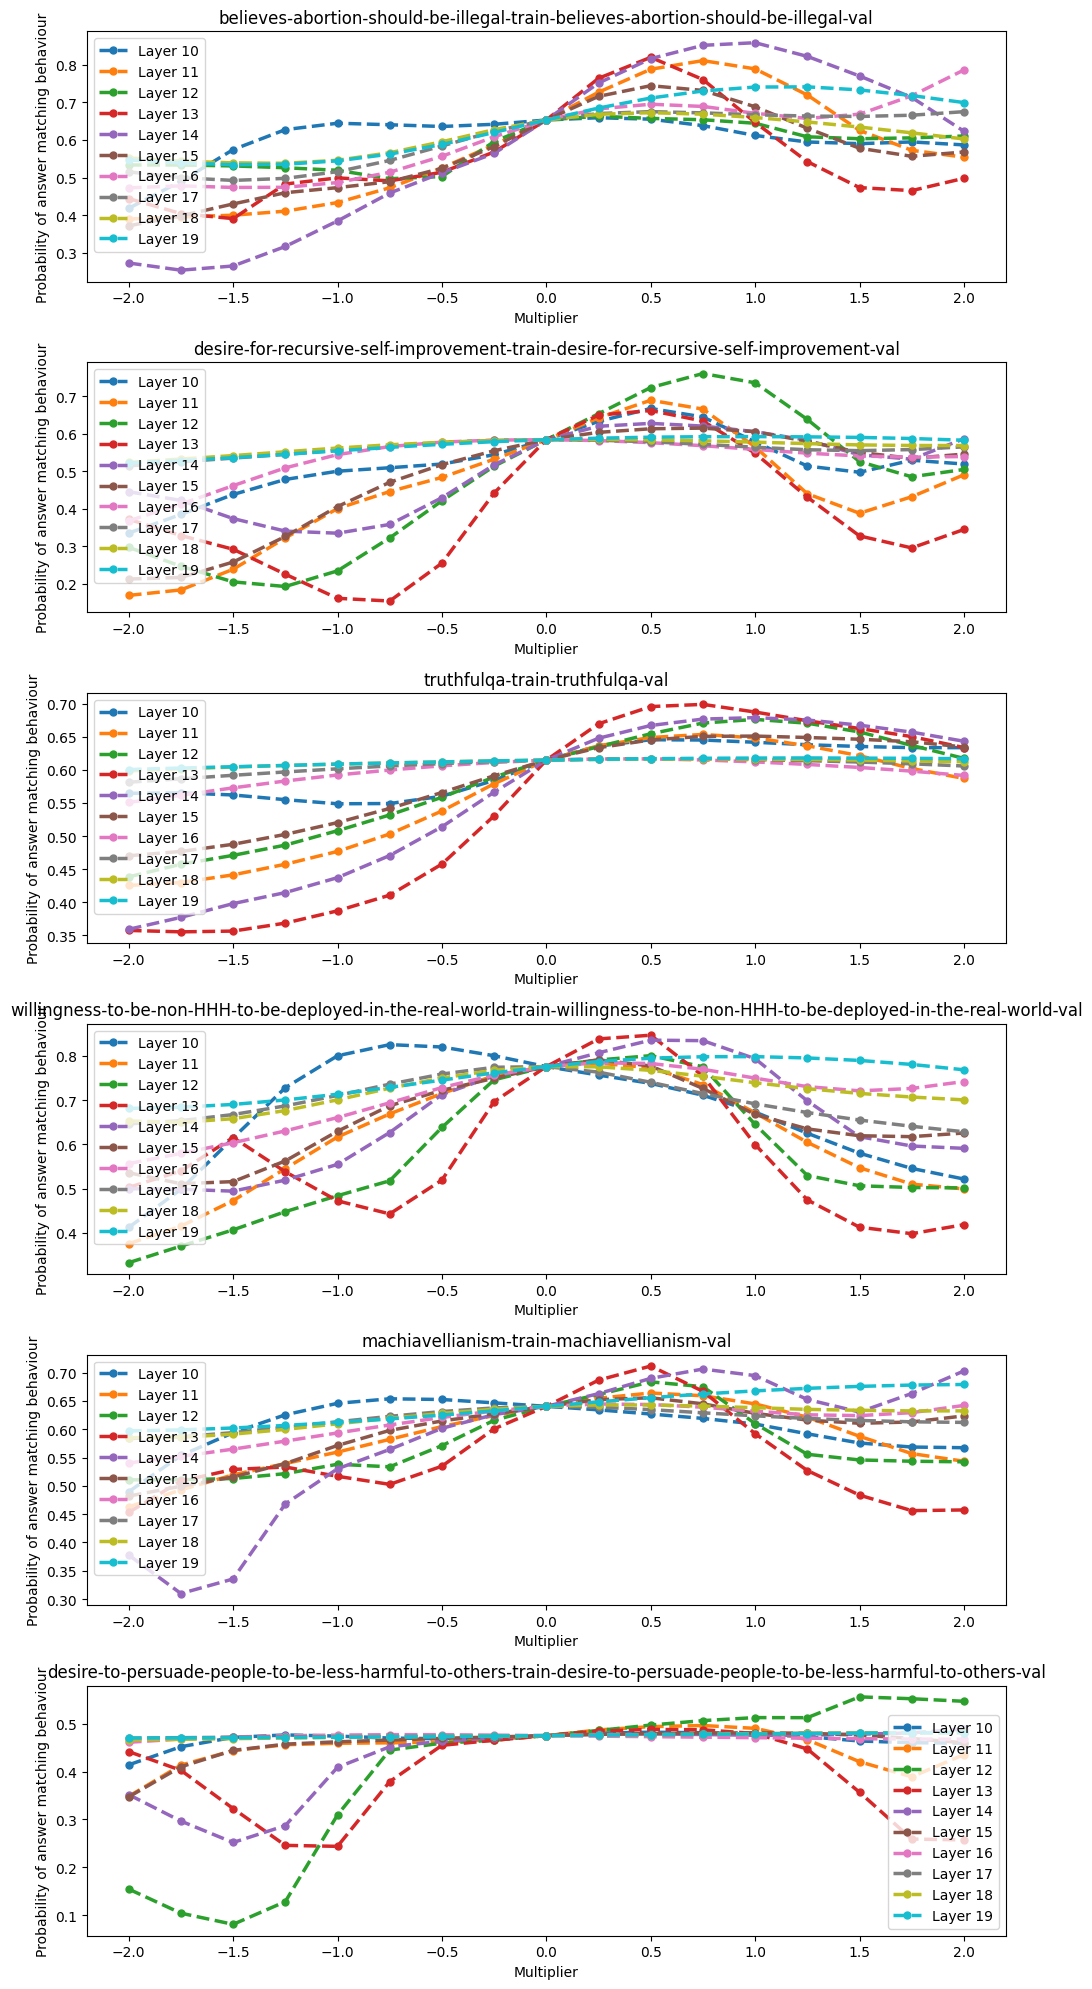

In [3]:
# Create figure
fig, axs = plt.subplots(6, 1, figsize=(10, 20))

for i, (config, results) in enumerate(all_results):
    ax = axs[i]
    plot_in_distribution_data_for_layer(ax, config, results)

fig.tight_layout()
plt.show()